In [ ]:
%matplotlib inline


분류기(Classifier) 학습하기
============================

이 강좌는 PyTorch [공식 튜토리얼](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)의 [번역본](https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)을 부분적으로 수정한 것이다.



데이터
------------------------

일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 때는 표준 Python 패키지를
이용하여 NumPy 배열로 불러오면 된다. 그 후 그 배열을 ``torch.Tensor``로 변환한다.

-  이미지는 PIL(Pillow)나 OpenCV 같은 패키지가 유용하다.
-  오디오를 처리할 때는 SciPy와 LibROSA가 유용하며,
-  텍스트의 경우에는 그냥 Python이나 Cython을 사용해도 되고, NLTK나 SpaCy도
   유용하다.

특별히 영상 분야를 위한 ``torchvision`` 패키지가 만들어져 있는데,
여기에는 ImageNet이나 CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한
데이터 로더(data loader), 즉 ``torchvision.datasets``과 이미지용 데이터 변환기
(data transformer), 즉 ``torch.utils.data.DataLoader``가 포함되어 있다.

이러한 기능은 매우 편리하며, 매번 유사한 코드를 반복해서
작성하는 것을 피할 수 있다.

이 튜토리얼에서는 CIFAR10 데이터셋을 사용한다. CIFAR10 데이터셋에는 다음과 같은 10개개 부류(class)의 이미지들이 있다: '비행기(airplane)', '자동차(automobile)', '새(bird)', '고양이(cat)',
'사슴(deer)', '개(dog)', '개구리(frog)', '말(horse)', '배(ship)', '트럭(truck)'.

CIFAR10에 포함된 이미지의 크기는 3x32x32로, 이는 32x32 픽셀 크기의 이미지가
3개 채널(channel)의 색상로 이뤄져 있다는 것을 뜻한다.

<img src="https://pytorch.org/tutorials/_images/cifar10.png" width="600" height="420">


이미지 분류기 학습하기
----------------------------

이하에서는 다음과 같은 단계로 이미지 분류기(classifier)를 학습해본다:

1. ``torchvision``을 사용하여 CIFAR10의 학습용/시험용 데이터셋을
   불러오고, 정규화(nomarlizing)한다.
2. 합성곱 신경망(Convolution Neural Network)을 정의한다.
3. 손실 함수를 정의한다.
4. 학습용 데이터를 사용하여 신경망을 학습한다.
5. 시험용 데이터를 사용하여 신경망을 검사한다.

## CIFAR10을 불러오고 정규화하기

``torchvision``을 사용하여 매우 쉽게 CIFAR10을 불러올 수 있다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지이다.
이를 [-1, 1]의 범위로 정규화된 Tensor로 변환한다.

**Note:** 만약 Windows 환경에서 `BrokenPipeError`가 발생한다면,
`torch.utils.data.DataLoader()`의 `num_worker`를 0으로 설정해보라.



In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     # transforms.Resize((32,32)),  # if necessary
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalizing by subtracting mean=0.5 and dividing std= 0.5 for each channel
    ]
    )

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


학습용 이미지 몇 개를 살펴보자.



torch.Size([4, 3, 32, 32])
tensor([[[ 0.0118,  0.0588,  0.0275,  ..., -0.1216, -0.0667,  0.0039],
         [ 0.1216,  0.1216,  0.0902,  ..., -0.1451, -0.0902, -0.0118],
         [ 0.2078,  0.1608,  0.0039,  ..., -0.0118,  0.0039,  0.0275],
         ...,
         [-0.1608, -0.2000, -0.2863,  ..., -0.2235, -0.1765, -0.1451],
         [-0.1843, -0.1922, -0.0902,  ..., -0.3098, -0.2392, -0.1451],
         [-0.2392, -0.2000, -0.1451,  ..., -0.4118, -0.2941, -0.1922]],

        [[ 0.0431,  0.0431,  0.0353,  ...,  0.0431,  0.0824,  0.1216],
         [ 0.1529,  0.1294,  0.1137,  ...,  0.0118,  0.0275,  0.0902],
         [ 0.2549,  0.2078,  0.0510,  ...,  0.0824,  0.0824,  0.1137],
         ...,
         [-0.0902, -0.1451, -0.2000,  ..., -0.0118, -0.0196, -0.0275],
         [-0.0824, -0.1059,  0.0275,  ..., -0.0431, -0.0275,  0.0039],
         [-0.1059, -0.0824,  0.0118,  ..., -0.1216, -0.0510,  0.0039]],

        [[-0.4196, -0.3725, -0.4196,  ..., -0.5373, -0.4745, -0.4353],
         [-0.2706,

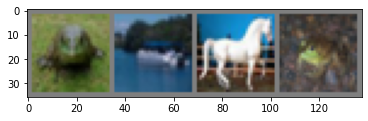

frog  ship  horse frog 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(images[0])
print(images[0].mean())
print(images[0].std())
print(images[0].min())
print(images[0].max())

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 합성곱 신경망(Convolution Neural Network) 정의하기

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # why 5 * 5? look below comment
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # input image: 3 channel RGB image of size 32x32
        # conv1: (3,32,32)->(6,28,28)
        # pool: (6,28,28)->(6,14,14)
        # conv2: (6,14,14)->(16,10,10)
        # pool: (16,10,10)->(16,5,5)
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

from torchsummary import summary
print(summary(net, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------
None


## 손실 함수와 Optimizer 정의하기

교차 엔트로피 손실(Cross-Entropy loss)과 모멘텀(momentum) 값을 갖는 SGD를 사용한다.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # momentum: don't get trapped inside local minima/maxima

## 신경망 학습하기

데이터를 반복해서 신경망에 입력으로 제공하고, 최적화(Optimize)한다.



In [ ]:
for epoch in range(20):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.241
[1,  4000] loss: 1.855
[1,  6000] loss: 1.655
[1,  8000] loss: 1.574
[1, 10000] loss: 1.537
[1, 12000] loss: 1.473
[2,  2000] loss: 1.399
[2,  4000] loss: 1.384
[2,  6000] loss: 1.359
[2,  8000] loss: 1.346
[2, 10000] loss: 1.337
[2, 12000] loss: 1.296
[3,  2000] loss: 1.237
[3,  4000] loss: 1.224
[3,  6000] loss: 1.232
[3,  8000] loss: 1.208
[3, 10000] loss: 1.194
[3, 12000] loss: 1.166
[4,  2000] loss: 1.124
[4,  4000] loss: 1.115
[4,  6000] loss: 1.102
[4,  8000] loss: 1.105
[4, 10000] loss: 1.117
[4, 12000] loss: 1.124
[5,  2000] loss: 1.032
[5,  4000] loss: 1.046
[5,  6000] loss: 1.063
[5,  8000] loss: 1.049
[5, 10000] loss: 1.053
[5, 12000] loss: 1.023
[6,  2000] loss: 0.935
[6,  4000] loss: 0.975
[6,  6000] loss: 0.989
[6,  8000] loss: 1.000
[6, 10000] loss: 1.010
[6, 12000] loss: 1.009
[7,  2000] loss: 0.895
[7,  4000] loss: 0.913
[7,  6000] loss: 0.956
[7,  8000] loss: 0.952
[7, 10000] loss: 0.958
[7, 12000] loss: 0.949
[8,  2000] loss: 0.852
[8,  4000] 

학습한 모델을 저장해보자:



In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

PyTorch 모델을 저장하는 자세한 방법은 [여기](<https://pytorch.org/docs/stable/notes/serialization.html>)
를 참조하라.

## 시험용 데이터로 신경망 검사하기

지금까지 학습용 데이터셋을 2회 반복하며 신경망을 학습시켰다.
신경망이 전혀 배운게 없을지도 모르니 확인해보자.

신경망이 예측한 출력과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인한다.
만약 예측이 맞다면 샘플을 '맞은 예측값(correct predictions)' 목록에 넣는다.

첫번째로 시험용 데이터를 살펴보자.



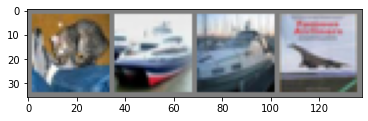

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

이제, 저장했던 모델을 불러온니다 (주: 모델을 저장하고 다시 불러오는
작업은 여기에서는 불필요하지만, 어떻게 하는지 설명을 위해 이렇게 해보자):



In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

 이제 이 예제들을 신경망이 어떻게 예측했는지를 보자:



In [ ]:
outputs = net(images)

출력은 10개 분류 각각에 대한 값으로 나타난다. 어떤 분류에 대해서 더 높은 값이
나타난다는 것은, 신경망이 그 이미지가 해당 분류에 더 가깝다고 생각한다는 것이다.
따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑아보자:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  frog  ship  plane ship 


이제 전체 데이터셋에 대해서는 어떻게 동작하는지 보자.



In [ ]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


(10가지 분류 중에 하나를 무작위로) 찍었을 때의 정확도인 10% 보다는 나아보인다.

그럼 어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못했는지 알아보자:



In [ ]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 64.2 %
Accuracy for class: car   is 71.2 %
Accuracy for class: bird  is 45.6 %
Accuracy for class: cat   is 34.7 %
Accuracy for class: deer  is 57.7 %
Accuracy for class: dog   is 46.9 %
Accuracy for class: frog  is 80.3 %
Accuracy for class: horse is 67.3 %
Accuracy for class: ship  is 78.6 %
Accuracy for class: truck is 67.3 %


## GPU에서 학습하기

Tensor를 GPU로 이동했던 것처럼, 신경망 또한 GPU로 옮길 수 있다.
먼저 (CUDA를 사용할 수 있다면) 첫번째 CUDA 장치를 사용하도록 설정한다:



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cpu


이 섹션의 나머지 부분에서는 ``device`` 를 CUDA 장치라고 가정하겠다.

그리고 이 메소드(Method)들은 재귀적으로 모든 모듈의 매개변수와 버퍼를
CUDA tensor로 변경한다:

        net.to(device)


또한, 각 단계에서 입력(input)과 정답(target)도 GPU로 보내야 한다는 것도 기억해야
한다:

        inputs, labels = data[0].to(device), data[1].to(device)

CPU와 비교했을 때 큰 속도 차이가 나지 않는 것은 왜일까?
이유는 바로 신경망이 너무 작기 때문이다.


**연습:** 신경망의 크기를 키워보고, 얼마나 빨라지는지 확인해보라.
(첫번째 ``nn.Conv2d``의 2번째 인자와 두번째 ``nn.Conv2d``의 1번째 인자는
같은 숫자여야 한다.)


## 여러 개의 GPU에서 학습하기

모든 GPU를 활용해서 더욱 더 속도를 올리고 싶다면, [문서](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html)를 참고하라.